In [274]:
# Boost Optimization EDA and Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)


## Prepare Data

In [275]:
# Load the data
data = pd.read_csv("data/boost_df.csv")

In [276]:
# Filter to only trips with at least 1 boost
boosted_trips = data[data['cumulative_boost_amount_cents'] > 0]

# Get the first boost timestamp per trip
first_boosts = boosted_trips.groupby('trip_id').agg({
    'created_at': 'first',
    'claimed_at': 'first',
    'scheduled_starts_at': 'first',
    'scheduled_ends_at': 'first',
    'origin_metro_area_name': 'first', 
    'commute_minutes': 'first', 
    'commute_distance': 'first', 
    'is_same_day_ride': 'first', 
    'trip_starts_during_peak_hours': 'first', 
    'total_predicted_duration_mins': 'first',
    'total_predicted_distance_miles': 'first', 
    'total_predicted_distance_miles_for_fare': 'first',
}).reset_index()

# Create the synthetic "pre-boost" rows
pre_boost_rows = pd.DataFrame({
    'trip_id': first_boosts['trip_id'],
    'boost_timestamp': first_boosts['created_at'], ## ***
    'created_at': first_boosts['created_at'],
    'scheduled_starts_at': first_boosts['scheduled_starts_at'],
    'scheduled_ends_at': first_boosts['scheduled_ends_at'],
    'claimed_at': first_boosts['claimed_at'],
    'origin_metro_area_name': first_boosts['origin_metro_area_name'], 
    'commute_minutes': first_boosts['commute_minutes'], 
    'commute_distance': first_boosts['commute_distance'], 
    'is_same_day_ride': first_boosts['is_same_day_ride'], 
    'trip_starts_during_peak_hours': first_boosts['trip_starts_during_peak_hours'], 
    'total_predicted_duration_mins': first_boosts['total_predicted_duration_mins'],
    'total_predicted_distance_miles': first_boosts['total_predicted_distance_miles'], 
    'total_predicted_distance_miles_for_fare': first_boosts['total_predicted_distance_miles_for_fare'],
    'cumulative_boost_amount_cents': 0,
    'seq_boost_count': 0,
    'boost_ind': 1
})

# Add other columns to match original DataFrame
columns_to_add = [col for col in data.columns if col not in pre_boost_rows.columns]
for col in columns_to_add:
    pre_boost_rows[col] = None  # or fill from joined trip metadata
# Concatenate with original data
data = pd.concat([data, pre_boost_rows], ignore_index=True)
data = data.sort_values(['trip_id','seq_boost_count'])

/var/folders/n7/pr4xbjnx1675ly58yn91qcsh0000gn/T/ipykernel_63945/3107754247.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, pre_boost_rows], ignore_index=True)


In [277]:
# Convert timestamps
date_cols = ["boost_timestamp", "created_at", "claimed_at", "scheduled_starts_at", "scheduled_ends_at", "unclaimed_at"]
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Create new time features
data['time_to_claim'] = (data['claimed_at'] - data['created_at']).dt.total_seconds() / 3600  # in hours
data['time_to_start'] = (data['scheduled_starts_at'] - data['created_at']).dt.total_seconds() / 3600
# Create key time to claim feature (later used for target)
data['time_to_claim_remaining_hrs'] = (data['claimed_at'] - data['boost_timestamp']).dt.total_seconds() / 3600
# Create cost features
data['final_boost_dollars'] = data.groupby('trip_id')['cumulative_boost_amount_cents'].transform('max')/100.
data['base_cost'] = data['dollars_paid_to_driver'] - data['final_boost_dollars']
data['pct_boost_cost'] = data['final_boost_dollars'] / data['dollars_paid_to_driver']

# Get first and last boost per trip
first_boost = data.groupby('trip_id')['boost_timestamp'].first()
last_boost = data.groupby('trip_id')['boost_timestamp'].last()
data['boost_duration'] = (last_boost - first_boost).dt.total_seconds() / 3600

# Filter out non-boosted rides
data = data[data['time_to_claim_remaining_hrs'] > 0]


In [278]:
# Time between trip creation and scheduled start
data['hrs_from_created_to_start'] = (data['scheduled_starts_at'] - data['created_at']).dt.total_seconds() / 3600

# Time between creation and claim
data['hrs_to_claim'] = (data['claimed_at'] - data['created_at']).dt.total_seconds() / 3600

# Time from claim to scheduled start
data['hrs_from_claim_to_start'] = (data['scheduled_starts_at'] - data['claimed_at']).dt.total_seconds() / 3600

# Time from claim to scheduled start
data['hrs_from_start_end'] = (data['scheduled_starts_at'] - data['scheduled_ends_at']).dt.total_seconds() / 3600

# When trip was created
data['created_hour'] = data['created_at'].dt.hour
data['created_dayofweek'] = data['created_at'].dt.day_name()

# When trip was claimed
data['claimed_hour'] = data['claimed_at'].dt.hour
data['claimed_dayofweek'] = data['claimed_at'].dt.day_name()

# When scheduled start
data['scheduled_start_hour'] = data['scheduled_starts_at'].dt.hour
data['scheduled_start_dayofweek'] = data['scheduled_starts_at'].dt.day_name()

# When scheduled end
data['scheduled_end_hour'] = data['scheduled_ends_at'].dt.hour
data['scheduled_end_dayofweek'] = data['scheduled_ends_at'].dt.day_name()

# Binning hours into categories (morning, afternoon, etc.)
def time_of_day(hour):
    if hour < 6:
        return 'early_morning'
    elif hour < 12:
        return 'morning'
    elif hour < 18:
        return 'afternoon'
    else:
        return 'evening'

data['created_time_bin'] = data['created_hour'].apply(time_of_day)
data['claimed_time_bin'] = data['claimed_hour'].apply(time_of_day)
data['scheduled_start_time_bin'] = data['scheduled_start_hour'].apply(time_of_day)
data['scheduled_end_time_bin'] = data['scheduled_end_hour'].apply(time_of_day)


## Construct Target Variable - Elasticity

In [279]:
# Prepare container for elasticity results
results = []

# Loop through trips with multiple boosts to compute an elasticity for each elegible trip_id
for trip_id, group in data.groupby('trip_id'):
    # requires trips with at least datapoints
    if len(group) >= 2:
        try:
            X = np.log(group['cumulative_boost_amount_cents']+1) # +1 to avoid log(0)
            y = np.log(group['time_to_claim_remaining_hrs']+1)

            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            elasticity = model.params.iloc[1]
            r2 = model.rsquared

            results.append({
                'trip_id': trip_id,
                'elasticity': elasticity,
                'r2': r2,
                'n_points': len(group)
            })
            
        except:
            continue

        # break

# Convert to DataFrame
elasticity_df = pd.DataFrame(results)

In [283]:
elasticity_df.head()

,trip_id,elasticity,r2,n_points
0,58,-1.356108,0.998236,3
1,62,-1.413088,1.000000,2
2,74,-1.325094,1.000000,2
3,75,-1.442742,1.000000,2
4,109,-1.432784,1.000000,2


In [285]:
elasticity_df.describe()

,trip_id,elasticity,r2,n_points
count,7470.000000,7470.000000,7470.000000,7470.000000
mean,213078.947657,-0.957788,0.997268,2.577912
std,106609.729480,0.307990,0.032763,0.894199
min,58.000000,-2.319514,0.347249,2.000000
25%,128920.500000,-1.152338,0.999878,2.000000
50%,224197.500000,-1.003578,1.000000,2.000000
75%,299375.000000,-0.824556,1.000000,3.000000
max,383347.000000,-0.000046,1.000000,12.000000


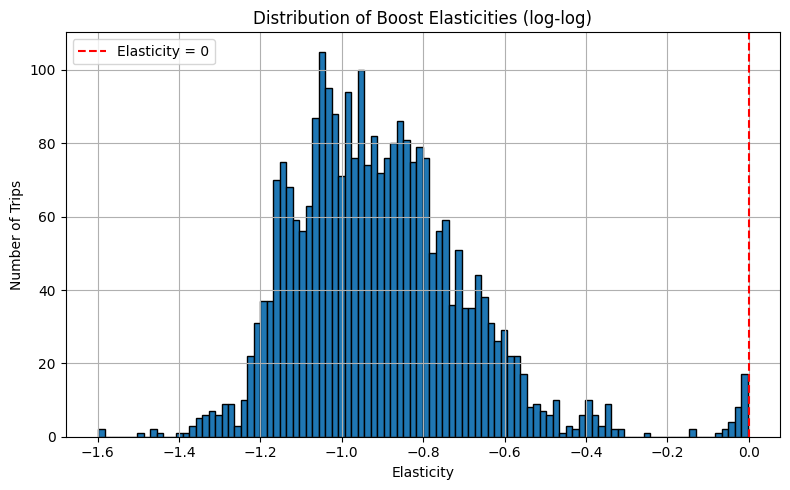

In [207]:
# Optional: Plot distribution of elasticity
plt.figure(figsize=(8,5))
plt.hist(elasticity_df[elasticity_df['n_points']>2]['elasticity'], bins=100, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='Elasticity = 0')
plt.title('Distribution of Boost Elasticities (log-log)')
plt.xlabel('Elasticity')
plt.ylabel('Number of Trips')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [286]:
data[data['trip_id']==256227]

,trip_id,cumulative_boost_amount_cents,boost_timestamp,manual_boost,boost_ind,seq_boost_count,single_boost_amount_cents,trip_state,created_at,claimed_at,scheduled_starts_at,scheduled_ends_at,unclaimed_at,trip_completed_at,total_predicted_duration_mins,total_predicted_distance_miles,total_predicted_distance_miles_for_fare,dollars_paid_to_driver,origin_metro_area_name,commute_minutes,commute_distance,is_same_day_ride,trip_starts_during_peak_hours,ever_unclaimed,time_to_claim,time_to_start,time_to_claim_remaining_hrs,final_boost_dollars,base_cost,pct_boost_cost,boost_duration,hrs_from_created_to_start,hrs_to_claim,hrs_from_claim_to_start,hrs_from_start_end,created_hour,created_dayofweek,claimed_hour,claimed_dayofweek,scheduled_start_hour,scheduled_start_dayofweek,scheduled_end_hour,scheduled_end_dayofweek,created_time_bin,claimed_time_bin,scheduled_start_time_bin,scheduled_end_time_bin
26373,256227,0.0,2024-05-10 20:50:06,None,1,0,NaN,None,2024-05-10 20:50:06,2024-06-10 15:11:11,2024-06-10 15:36:54,2024-06-10 16:25:00,NaT,None,33.67,17.76,17.75,NaN,DFW,24.3,12.86,False,True,None,738.351389,738.78,738.351389,2.807,NaN,NaN,NaN,738.78,738.351389,0.428611,-0.801667,20,Friday,15,Monday,15.0,Monday,16,Monday,evening,afternoon,afternoon,afternoon
14063,256227,279.3,2024-06-10 14:20:09,1,1,1,279.3,complete,2024-05-10 20:50:06,2024-06-10 15:11:11,2024-06-10 15:36:54,2024-06-10 16:25:00,2024-06-10 07:09:41,2024-06-10 16:37:12,33.67,17.76,17.75,45.04,DFW,24.3,12.86,False,True,1,738.351389,738.78,0.850556,2.807,42.233,0.062322,NaN,738.78,738.351389,0.428611,-0.801667,20,Friday,15,Monday,15.0,Monday,16,Monday,evening,afternoon,afternoon,afternoon
14064,256227,280.7,2024-06-10 14:46:08,1,1,2,1.4,complete,2024-05-10 20:50:06,2024-06-10 15:11:11,2024-06-10 15:36:54,2024-06-10 16:25:00,2024-06-10 07:09:41,2024-06-10 16:37:12,33.67,17.76,17.75,45.04,DFW,24.3,12.86,False,True,1,738.351389,738.78,0.417500,2.807,42.233,0.062322,NaN,738.78,738.351389,0.428611,-0.801667,20,Friday,15,Monday,15.0,Monday,16,Monday,evening,afternoon,afternoon,afternoon


## Prepare Modeling Dataset

In [287]:
# Compress data features to trip level
trip_features = data.drop_duplicates('trip_id', keep='last')[[
    'trip_id', 'base_cost',
    'origin_metro_area_name', 'commute_minutes', 'commute_distance', 'is_same_day_ride', 'trip_starts_during_peak_hours', 
    'total_predicted_duration_mins', 'total_predicted_distance_miles', 'total_predicted_distance_miles_for_fare',
    'hrs_from_created_to_start', 'hrs_to_claim', 'hrs_from_claim_to_start', 'hrs_from_start_end', 
    'created_hour', 'created_dayofweek', 'claimed_hour', 'claimed_dayofweek', 'scheduled_start_hour', 'scheduled_start_dayofweek', 'scheduled_end_hour', 'scheduled_end_dayofweek', 'created_time_bin', 'claimed_time_bin',
    'scheduled_start_time_bin', 'scheduled_end_time_bin'
]]

# Join target elasticities to dataset based on the trip_id
elasticity_full = elasticity_df[['trip_id','elasticity']].merge(trip_features, on='trip_id', how='left')

In [288]:
elasticity_full.shape

(7470, 27)

In [212]:
elasticity_full.head()

,trip_id,elasticity,base_cost,origin_metro_area_name,commute_minutes,commute_distance,is_same_day_ride,trip_starts_during_peak_hours,total_predicted_duration_mins,total_predicted_distance_miles,total_predicted_distance_miles_for_fare,hrs_from_created_to_start,hrs_to_claim,hrs_from_claim_to_start,hrs_from_start_end,created_hour,created_dayofweek,claimed_hour,claimed_dayofweek,scheduled_start_hour,scheduled_start_dayofweek,scheduled_end_hour,scheduled_end_dayofweek,created_time_bin,claimed_time_bin,scheduled_start_time_bin,scheduled_end_time_bin
0,58,-1.356108,25.959,Greensboro Metro,29.92,8.90,False,True,28.58,19.19,19.19,8615.863333,8615.057778,0.805556,-0.680556,15,Monday,14,Wednesday,15.0,Wednesday,16,Wednesday,afternoon,afternoon,afternoon,afternoon
1,62,-1.413088,25.490,Greensboro Metro,14.50,2.04,False,True,27.24,19.19,19.19,8927.395278,8926.632778,0.762500,-0.648611,15,Monday,14,Tuesday,15.0,Tuesday,15,Tuesday,afternoon,afternoon,afternoon,afternoon
2,74,-1.325094,28.700,Greensboro Metro,35.17,18.91,False,True,31.00,19.40,19.40,8910.121389,8909.409722,0.711667,-0.738056,15,Monday,21,Monday,21.0,Monday,22,Monday,afternoon,evening,evening,evening
3,75,-1.442742,33.502,Greensboro Metro,9.74,4.25,False,True,31.00,19.40,19.40,9006.121389,9005.698611,0.422778,-0.738056,15,Monday,21,Friday,21.0,Friday,22,Friday,afternoon,evening,evening,evening
4,109,-1.432784,34.384,Greensboro Metro,20.34,10.82,False,True,36.73,22.25,22.25,8516.888333,8516.291111,0.597222,-0.874444,18,Friday,14,Wednesday,15.0,Wednesday,15,Wednesday,evening,afternoon,afternoon,afternoon


In [215]:
elasticity_full.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7470 entries, 0 to 7469
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   trip_id                                  7470 non-null   int64  
 1   elasticity                               7470 non-null   float64
 2   base_cost                                7470 non-null   float64
 3   origin_metro_area_name                   7470 non-null   object 
 4   commute_minutes                          7470 non-null   float64
 5   commute_distance                         7469 non-null   float64
 6   is_same_day_ride                         7470 non-null   bool   
 7   trip_starts_during_peak_hours            7470 non-null   bool   
 8   total_predicted_duration_mins            7470 non-null   float64
 9   total_predicted_distance_miles           7470 non-null   float64
 10  total_predicted_distance_miles_for_fare  7470 no

## Build Regression Model to Predict Elasticity

In [262]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import xgboost as xgb

# Target variable
y = elasticity_full['elasticity']
X = elasticity_full.drop(columns=['elasticity'])
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Column types
numeric_features = ['commute_minutes', 'commute_distance', 'total_predicted_duration_mins', 'total_predicted_distance_miles', 'total_predicted_distance_miles_for_fare',
                    'hrs_from_created_to_start', 'hrs_from_start_end', 'base_cost']
categorical_features = ['origin_metro_area_name', 
                       'created_dayofweek', 'scheduled_start_dayofweek', 'scheduled_end_dayofweek',
                       'created_time_bin', 'scheduled_start_time_bin', 'scheduled_end_time_bin',
                       'is_same_day_ride', 'trip_starts_during_peak_hours']

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# model parameters
models = {
    'linreg': {
        'model': LinearRegression(),
        'params': {}
    },
    'ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.1, 1.0, 10.0]
        }
    },
    'rf': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'model__n_estimators': [100, 1000],
            'model__max_depth': [3, 5]
        }
    },
    'xgb': {
        'model': xgb.XGBRegressor(random_state=42, verbosity=0),
        'params': {
            'model__n_estimators': [100, 1000],
            'model__max_depth': [3, 5],
            'model__learning_rate': [0.05, 0.1]
        }
    }
}


results = {}
# Loop through each model parameter instance and run gridsearch to determine best model
for name, cfg in models.items():
    # Final pipeline: preprocess + model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', cfg['model'])
    ])

    print(f"Running GridSearch for: {name}")
    grid = GridSearchCV(model_pipeline, cfg['params'], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)

    # Get best model
    best_model = grid.best_estimator_
    # get cv for only the best model result
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    mean_cv_score = np.mean(cv_scores)

    # Predict
    y_pred = best_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    results[name] = {
        'best_params': grid.best_params_,
        'rmse': rmse,
        'model': best_model,
        'mean_cv_score': mean_cv_score,
    }

# Show summary
for name, res in results.items():
    print(f"\n{name.upper()}:\nBest Params: {res['best_params']}\nRMSE: {res['rmse']:.4f}")

Running GridSearch for: linreg
Running GridSearch for: ridge
Running GridSearch for: rf
Running GridSearch for: xgb

LINREG:
Best Params: {}
RMSE: 0.1623

RIDGE:
Best Params: {'model__alpha': 10.0}
RMSE: 0.1602

RF:
Best Params: {'model__max_depth': 5, 'model__n_estimators': 100}
RMSE: 0.1298

XGB:
Best Params: {'model__learning_rate': 0.05, 'model__max_depth': 5, 'model__n_estimators': 1000}
RMSE: 0.1153


In [263]:
results

{'linreg': {'best_params': {},
  'rmse': 0.16229542795396246,
  'model': Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('num',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer()),
                                                                    ('scaler',
                                                                     StandardScaler())]),
                                                    ['commute_minutes',
                                                     'commute_distance',
                                                     'total_predicted_duration_mins',
                                                     'total_predicted_distance_miles',
                                                     'total_predicted_distance_miles_for_fare',
                                                     'hrs_from_created_to_start',
   

## Optimize Objective

In [326]:
## now that we are about predict price elasticity, we can simulate different cost scenarios to get at our desired time to ride claim

In [320]:
def predict_elasticity(elasticity):
    # Placeholder for now but will return price elasticity for given trip_id
    return elasticity


def simulate_and_optimize_boost(elasticity, 
                                base_boost, # current cumulative cost paid to driver
                                baseline_time_to_claim, # current diff between created trip time and scheduled start
                                boost_max_factor=5.0, 
                                num_points=20, 
                                lambda_tradeoff=0.5): # low prioritizes lower claim time and high prioritizes lower boost cost
    # mockup
    elasticity = predict_elasticity(elasticity)

    # generate simulated boost range
    boost_range = np.linspace(base_boost, base_boost * boost_max_factor, num_points)
    results = []

    for boost in boost_range:
        
        ratio = boost / base_boost if base_boost > 0 else 1.0
        predicted_time = baseline_time_to_claim * (ratio ** elasticity)
        predicted_cost = boost
        # weighted objective between time to claim and boost cost
        objective = (1-lambda_tradeoff) * predicted_time + lambda_tradeoff * predicted_cost
        
        results.append({
            'boost': boost,
            'predicted_time_to_claim': predicted_time,
            'predicted_cost': predicted_cost,
            'objective': objective
        })

    results_df = pd.DataFrame(results)
    optimal_row = results_df.loc[results_df['objective'].idxmin()]

    return optimal_row, results_df


def plot_boost_tradeoff(df, optimal_boost):
    plt.figure(figsize=(10, 6))
    # plt.plot(df['boost'], df['predicted_time_to_claim'], label='Predicted Time to Claim', color='blue')
    # plt.plot(df['boost'], df['predicted_cost'], label='Predicted Cost', color='orange', linestyle='--')
    plt.plot(df['boost'], df['objective'], label='Objective Function', color='green', linestyle='-.')
    
    plt.axvline(optimal_boost, color='red', linestyle=':', label=f'Optimal Boost: {optimal_boost:.2f}')
    
    plt.xlabel('Boost Amount')
    plt.ylabel('Value')
    plt.title('Boost Optimization Tradeoff')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Test Scenario, Elasticity = -0.5

In [321]:
optimal_row, results_df = simulate_and_optimize_boost(
        elasticity=-0.5,
        base_boost=5, #dollars
        baseline_time_to_claim=24,#hours
    )

In [314]:
results_df

,boost,predicted_time_to_claim,predicted_cost,objective
0,5.000000,24.000000,5.000000,14.500000
1,6.052632,21.813438,6.052632,13.933035
2,7.105263,20.132892,7.105263,13.619077
3,8.157895,18.789153,8.157895,13.473524
4,9.210526,17.682922,9.210526,13.446724
5,10.263158,16.751579,10.263158,13.507368
6,11.315789,15.953421,11.315789,13.634605
7,12.368421,15.259458,12.368421,13.813940
8,13.421053,14.648831,13.421053,14.034942
9,14.473684,14.106092,14.473684,14.289888


In [316]:
optimal_row

boost                       9.210526
predicted_time_to_claim    17.682922
predicted_cost              9.210526
objective                  13.446724
Name: 4, dtype: float64

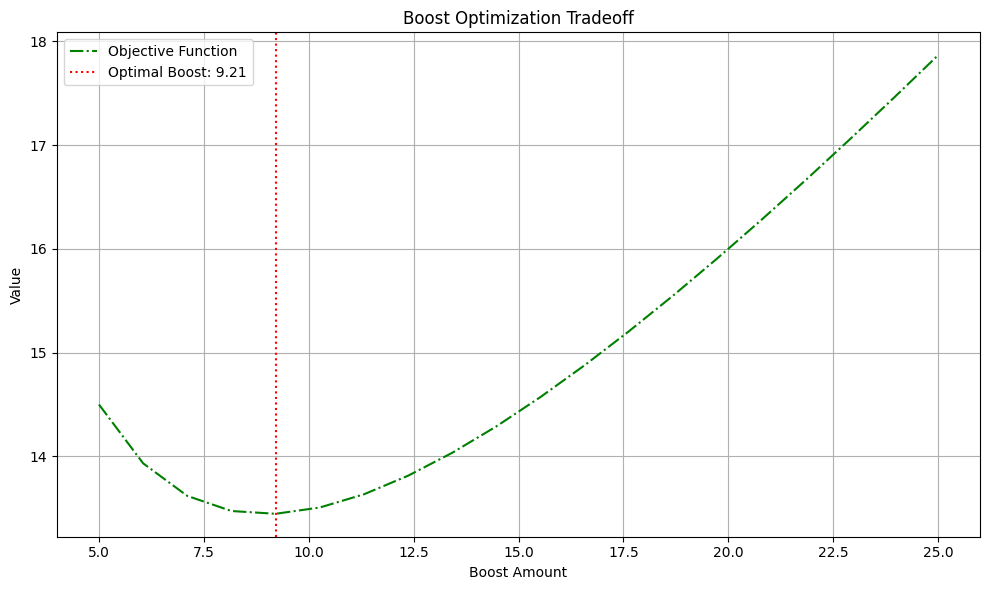

In [322]:
plot_boost_tradeoff(results_df, optimal_row['boost'])

## Test Scenario, Elasticity = -1.5

In [323]:
optimal_row, results_df = simulate_and_optimize_boost(
        elasticity=-1.5,
        base_boost=5, #dollars
        baseline_time_to_claim=24,#hours
    )

In [325]:
results_df

,boost,predicted_time_to_claim,predicted_cost,objective
0,5.000000,24.000000,5.000000,14.500000
1,6.052632,18.019797,6.052632,12.036214
2,7.105263,14.167591,7.105263,10.636427
3,8.157895,11.515932,8.157895,9.836914
4,9.210526,9.599300,9.210526,9.404913
5,10.263158,8.161025,10.263158,9.212092
6,11.315789,7.049186,11.315789,9.182488
7,12.368421,6.168717,12.368421,9.268569
8,13.421053,5.457407,13.421053,9.439230
9,14.473684,4.873013,14.473684,9.673349


In [327]:
optimal_row

boost                      11.315789
predicted_time_to_claim     7.049186
predicted_cost             11.315789
objective                   9.182488
Name: 6, dtype: float64

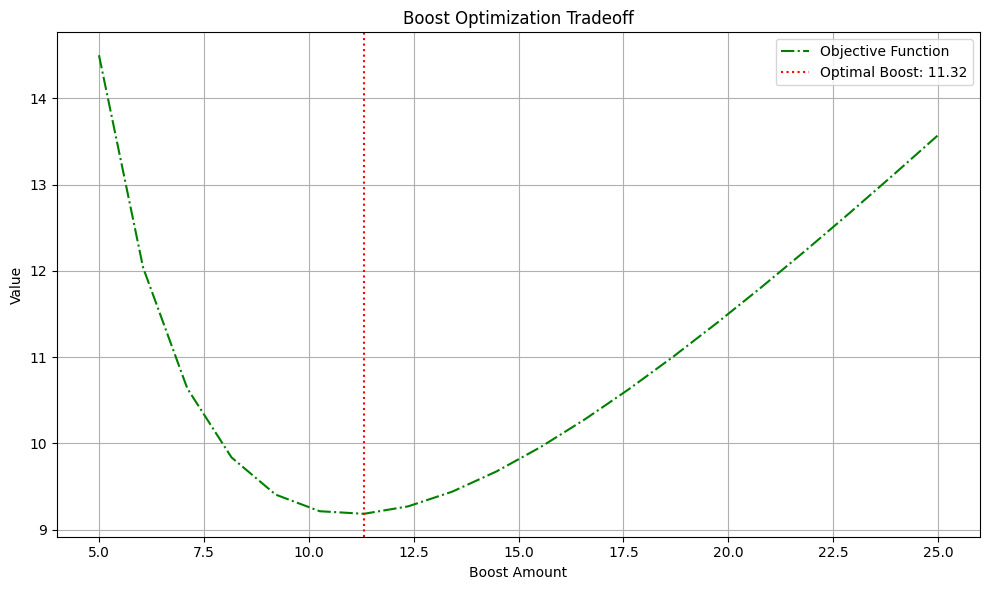

In [324]:
plot_boost_tradeoff(results_df, optimal_row['boost'])